In [2]:
%matplotlib inline
import numpy as n
import matplotlib.pyplot as p
import healpy as hp
pi=n.pi
import copy
import scipy.optimize as op
c=299792458

In [3]:
#take a cut through a beam
def hpCut(phi,nPix,data):
    nSide=hp.npix2nside(len(data))
    output=n.zeros(nPix)
    thetaVals=n.arange(nPix/2)/(nPix/2.)*pi/2.
    thetaVals=n.hstack([n.flipud(thetaVals),thetaVals,]).T
    phiVals=n.ones(len(thetaVals))
    phi1=phi+pi
    phiVals[:nPix/2]=phi1
    phiVals[nPix/2:]=phi
    output=hp.get_interp_val(data,thetaVals,phiVals)
    return output


#rotate
def rotateBeam(inputMap,rot=[90,0,0]):
    rotator=hp.Rotator(rot=rot)
    npix=len(inputMap)
    nside=hp.npix2nside(npix)
    theta,phi=hp.pix2ang(nside,range(npix))
    newtheta,newphi=rotator(theta,phi)
    output=hp.get_interp_val(inputMap,newtheta,newphi)
    return output
    


class Beam:
    def __init__(self,nside=64,pols=['XX','YY'],rotateY=False,invert=False,rotatexz=False):
        self.nside=nside
        self.npolsOriginal=len(pols)
        self.npols=max(len(pols),2)
        self.nPix=hp.nside2npix(nside)
        self.nSide=nside
        self.invert=invert
        self.pixArea=hp.nside2pixarea(self.nSide)
        self.pols=pols
        self.rotatexz=rotatexz
        if(rotateY):
            pols.append('YY')
            
    def _interp_beam(self,beam_file,pol,chan):
        data=n.loadtxt(beam_file,skiprows=2);
        theta,phi=hp.pix2ang(self.nSide,range(self.nPix))
        theta=n.round(n.degrees(theta)).astype(int)
        phi=n.round(n.degrees(phi)).astype(int)
        self.data[pol,chan,:]=10**((data[:,2].squeeze().reshape(360,181))[phi,theta]/10.)
        self.data[pol,chan,:]/=self.data[pol,chan,:].flatten().max();    
        if self.rotatexz:
            self.data[pol,chan,:]=rotateBeam(self.data[pol,chan,:].flatten(),rot=[0,-90,0])
        if(self.invert):
            self.data[pol,chan,:]=rotateBeam(self.data[pol,chan,:].flatten(),rot=[0,180,0])
        self.data[pol,chan,theta>90.]=0.
        self.solidAngles[pol,chan]=self.pixArea*n.sum(self.data[pol,chan,:])
        self.effArea[pol,chan]=(c/(self.fAxis[chan]))**2./self.solidAngles[pol,chan]
        if(self.npolsOriginal==1):
            self.data[1,chan,:]=rotateBeam(self.data[0,chan,:].flatten())
            self.solidAngles[1,chan]=self.pixArea*n.sum(self.data[1,chan,:])
            self.effArea[1,chan]=(c/(self.fAxis[chan]))**2./(self.solidAngles[1,chan])
        if(len(self.pols)>1 and self.pols[0]=='XX' and self.pols[1]=='YY'):
            self.ellipticity[chan]=n.sum((self.data[0,chan]-self.data[1,chan])**2.)/n.sum((self.data[0,chan]+self.data[1,chan])**2.)
    def read_files(self,flist,filelist):
        self.nf=len(flist)
        self.fAxis=n.zeros(self.nf)
        self.data=n.zeros((self.npols,self.nf,self.nPix))   
        self.solidAngles=n.zeros((self.npols,self.nf))
        self.effArea=n.zeros_like(self.solidAngles)
        self.ellipticity=n.zeros(self.nf)

        for m in range(self.nf):
            tempf=flist[m].split('p')
            self.fAxis[m]=float(tempf[0])*1e6
            for p in range(self.npolsOriginal):
                self._interp_beam(filelist[p*self.nf+m],p,m)
                
                
class FeedData:
    def __init__(self,fListFeedOnly,fListFeedOverDish,
                 freqList,nside,
                 pols=['XX','YY'],rotateY=False,
                 invertFeedOnly=True,
                 invertDish=True,
                 dDish=14.,dFocus=4.5,rotatexz=False):
        self.nf=len(freqList)
        self.nSide=nside
        self.nPix=hp.nside2npix(nside)
        self.daveFeedEfficiency=n.zeros(self.nf)
        self.daveTaper=n.zeros(self.nf)
        self.davePol=n.zeros(self.nf)
        self.daveBeamEfficiency=n.zeros(self.nf)
        self.dDish=dDish
        self.dFocus=dFocus
        self.thetaEdge=2.*n.arctan(self.dDish/(4.*self.dFocus))
        self.beamFeedAndDish=Beam(nside,copy.deepcopy(pols),rotateY,invertDish,rotatexz=rotatexz)
        self.beamFeedAndDish.read_files(freqList,fListFeedOverDish)
        self.beamFeedOnly=Beam(nside,pols,rotateY,invertFeedOnly)
        self.beamFeedOnly.read_files(freqList,fListFeedOnly)
        self.fAxis=self.beamFeedOnly.fAxis
        self.beamFWHM=n.zeros(len(self.fAxis))
        self.gain=4.*pi/self.beamFeedAndDish.solidAngles[0,:]
        theta,phi=hp.pix2ang(self.nSide,range(self.nPix))


        self.nSide=nside
        self.nPix=hp.nside2npix(self.nSide)
        self.pols=self.beamFeedAndDish.pols
        for mm in range(self.nf):
            dataFeed=self.beamFeedOnly.data[0,mm,:]
            dataDish=self.beamFeedAndDish.data[0,mm,:]
            #compute feed efficiency by integrating feed beam intercepted by dish
            selectionEdge=theta<self.thetaEdge
            self.daveFeedEfficiency[mm]=n.sum(dataFeed[selectionEdge])/n.sum(dataFeed)
            #compute taper by averaging gain on ring at dish edge
            phiRange=n.radians(n.arange(0,360))
            thetaRange=n.ones(len(phiRange))*self.thetaEdge
            self.daveTaper[mm]=1./n.mean(hp.get_interp_val(dataFeed,thetaRange,phiRange))
            #compute polarization mismatch by integrating phi=0 and phi=90
            thetaRange=n.radians(n.arange(0,180))
            phiRange=n.ones(len(thetaRange))*0.
            xArc=hp.get_interp_val(dataDish,thetaRange,phiRange)
            yArc=hp.get_interp_val(dataDish,thetaRange,phiRange+pi/2.)
            self.davePol[mm]=n.sum((n.sqrt(xArc)-n.sqrt(yArc))**2.)/n.sum((n.sqrt(xArc)+n.sqrt(yArc))**2.)
            #compute beam efficiency. First determine FWHM by taking average in 360 degree ring. 
            stddevs=[]
            nth=1000
            tha=n.arange(-nth/2,nth/2)*pi/nth
            for nn in range(0,180,10):
                cut=hpCut(n.radians(nn),nth,dataDish)
                try:
                    stddevs.append(op.curve_fit(lambda x,p: n.exp(-x**2./(2.*p**2.)),tha,cut,p0=[n.radians(15.)])[0])
                except Exception as e:
                    print e
                    print 'error'
                    p.plot(tha,cut)
                    p.yscale('log')
                    p.show()
            stddeves=n.array(stddevs)
            stddev=n.max(stddevs)
            fwhm=2.*n.sqrt(2.*n.log(2.))*stddev
            self.beamFWHM[mm]=fwhm
            selectionFWHM=theta<fwhm/2.
            self.daveBeamEfficiency[mm]=n.sum(dataDish[selectionFWHM])/n.sum(dataDish)

In [20]:
n.array(154.328+n.array([m*(231.492-154.328)/4 for m in range(5)]))

array([ 154.328,  173.619,  192.91 ,  212.201,  231.492])

In [4]:
rigging_heights=n.array(154.328+n.array([m*(231.492-154.328)/4 for m in range(5)]))/12./3.28084

In [5]:
#beamCylinder=Beam('beamCylinder',['100'],64)
fstrList=[str(m) for m in range(50,155,5)]
beamDirList=['../data/beams/varyRiggingHeight_short/beamVaryRiggingHeight_run00000%d/'%m for m in range(1,6)]
beamDirFeedOnly='../data/beams/beamCosmicTwilightPolarimeter_diskConnect_short/'
feeds=[]
for run,rigging_height in zip(beamDirList,rigging_heights):
    fList=[(run+'farfield (f=%s) [1].txt')%(s) for s in fstrList]
    fListFeedOnly=[beamDirFeedOnly + 'farfield (f=%s) [1].txt'%s for s in fstrList]
    feed=FeedData(fListFeedOnly=fListFeedOnly,
                  fListFeedOverDish=fList,
                  freqList=fstrList,
                  nside=64,
                  pols=['XX'],
                  rotateY=True,
                  invertFeedOnly=False,
                  rotatexz=True,
                  dFocus=rigging_height)
    feeds.append(feed)

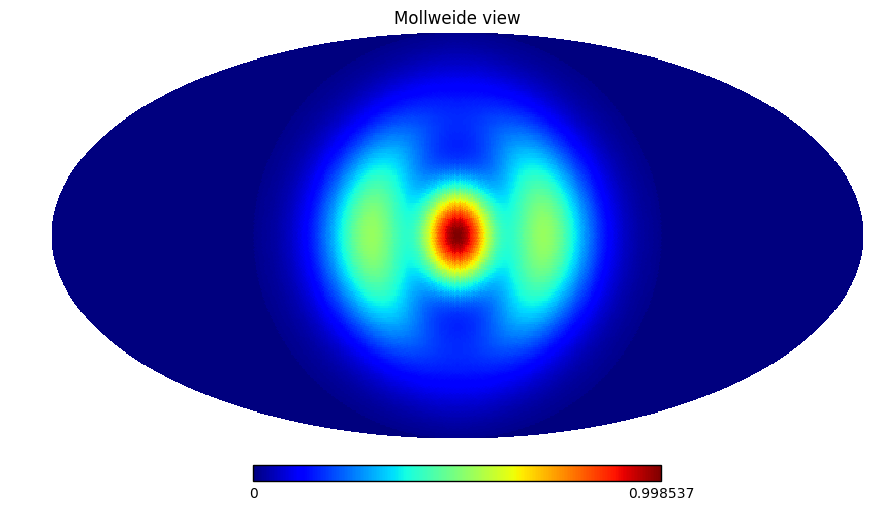

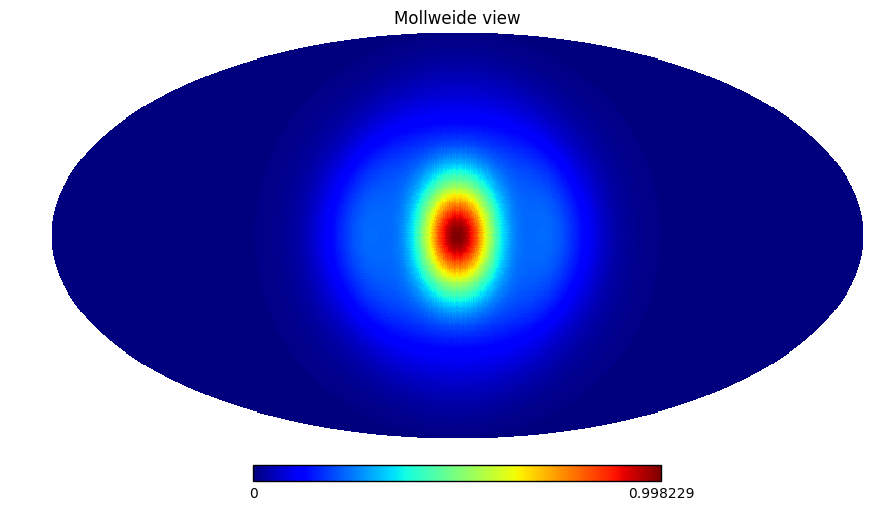

In [6]:
hp.mollview(feeds[0].beamFeedAndDish.data[0,0,:],rot=(0,90,0))
hp.mollview(feeds[-1].beamFeedAndDish.data[0,0,:],rot=(0,90,0))

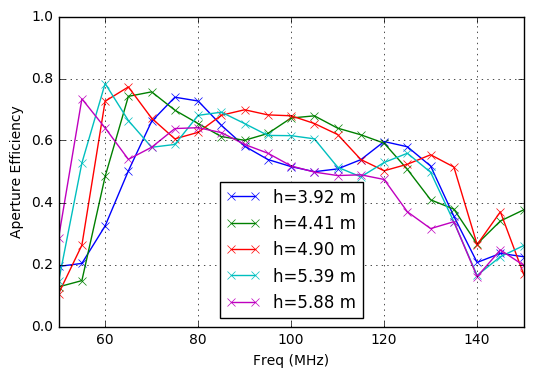

In [19]:

for lnum,(feed,height) in enumerate(zip(feeds,rigging_heights)):
    p.plot(feed.fAxis/1e6,feed.beamFeedAndDish.effArea[0]/(n.pi*7**2.),
           ls='-',marker='x',label='h=%.2f m'%(height),
          )

p.xlim(50,150)
p.ylim(0,1)
p.grid()
p.xlabel('Freq (MHz)')
p.ylabel('Aperture Efficiency')
p.legend(loc='best')
p.savefig('area_efficiency_vs_height_short.png')



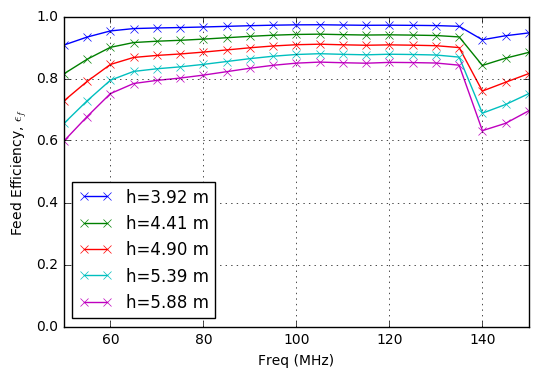

In [8]:
for feed,height in zip(feeds,rigging_heights):
    p.plot(feed.fAxis/1e6,feed.daveFeedEfficiency,ls='-',marker='x',label='h=%.2f m'%(height))

p.xlim(50,150)
p.ylim(0,1)
p.grid()
p.xlabel('Freq (MHz)')
p.ylabel('Feed Efficiency, $\\epsilon_f$')
p.legend(loc='best')
p.savefig('feed_efficiency_vs_height_short.png')



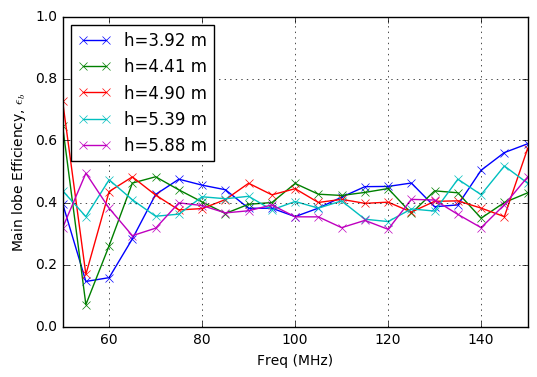

In [9]:
for feed,height in zip(feeds,rigging_heights):
    p.plot(feed.fAxis/1e6,feed.daveBeamEfficiency,ls='-',marker='x',label='h=%.2f m'%(height))

p.xlim(50,150)
p.ylim(0,1)
p.grid()
p.xlabel('Freq (MHz)')
p.ylabel('Main lobe Efficiency, $\\epsilon_b$')
p.legend(loc='best')
p.savefig('beam_efficiency_vs_height_short.png')




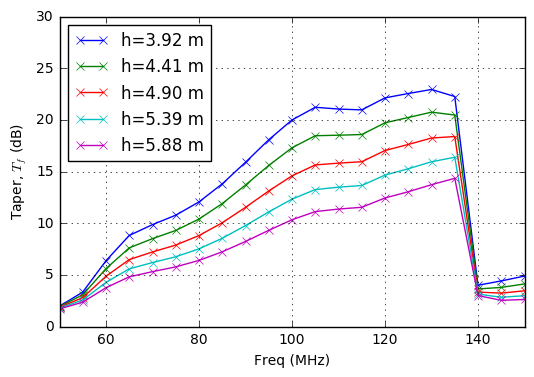

In [11]:
for feed,height in zip(feeds,rigging_heights):
    p.plot(feed.fAxis/1e6,feed.daveTaper,ls='-',marker='x',label='h=%.2f m'%(height))

p.xlim(50,150)
p.ylim(0,30)
p.grid()
p.xlabel('Freq (MHz)')
p.ylabel('Taper, $T_f$ (dB)')
p.legend(loc='best')
p.savefig('feed_taper_vs_height_short.png')



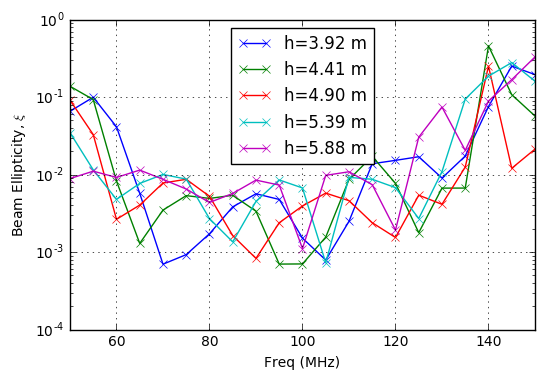

In [12]:
for feed,height in zip(feeds,rigging_heights):
    p.plot(feed.fAxis[::1]/1e6,feed.beamFeedAndDish.ellipticity[::1],ls='-',marker='x',label='h=%.2f m'%(height))

p.xlim(50,150)
#p.ylim(0,1)
p.grid()
p.xlabel('Freq (MHz)')
p.ylabel('Beam Ellipticity, $\\xi$')
p.legend(loc='best')
p.savefig('feed_pol_vs_height_short.png')
p.yscale('log')
